<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment1/workbook-task1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO: Modify this cell to add your group name, group number and your names and student IDs

Group: 51

Authors:

In [1]:
import requests
import io
import torch
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Training data set

For task 1 of Assignment 1 you need to use a specific data set prepared using images from the [Omniglot dataset](https://github.com/brendenlake/omniglot). The provided training data set contains 18.800 binary images of handwritten characters of size (28,28). Each of these images depicts one of 893 different characters from 29 different alphabets. Each image is accompanied by a label that is encoded as an interger $y\in\{0, 1, ..., 892\}$ that indicate the caracter depicted in the image. The following cell provides code that loads the data from hardcoded URLs.

You can use the code in this cell to load the dataset or download the data set from the given URLs to your local drive (or your Google drive) and modify the code to load the data from another location. 


In [2]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
    
    
    
# Downloading may take a while..
train_x = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/tvQmLyY7MhVsADb/download')
train_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/z234AHrQqx9RVGH/download')

print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}\n")
train_x_ge = (train_x.reshape((-1,784))/255)
train_x_ge1 = torch.from_numpy(train_x_ge)
train_x_re = train_x_ge1.type(torch.FloatTensor)
train_y_re = torch.from_numpy(train_y)
print(train_x_re)
print(train_y_re)



train_x shape: (18800, 28, 28)
train_y shape: (18800,)

tensor([[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
        [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
        [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
        ...,
        [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
        [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
        [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]])
tensor([  1,   1,   1,  ..., 964, 964, 964])


### Query data set

For this task you need to use the following query data set. The dataset contains 100 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set. The characters in the query data set all come from the Greek alphabet that is not part of the set of alphabets in the training data. 

Each test set consists of 1 query image and 5 candidate images. All images are the same size (28x28). The test data is organized in two numpy arrays. One for the query images with shape (100, 1, 28, 28) and another for the candidate imagaes with shape (100, 5, 28, 28). 

The task is to develop a model that enables selecting the image which is depicting the same character as the anchor image out of 5 test images. These test images are declared in the `query_x` numpy array . 

Finally, we plot the first 5 cases in the query dataset. The first column corresponds with the anchor images of each of the 5 cases. All other images are test images from which the task is to recognize the anchor image. The image enclosed in a red box denotes the target image that your model should be able to recognize as the same class as the anchor image. 

In [3]:
query_dataset = load_numpy_arr_from_url("https://surfdrive.surf.nl/files/index.php/s/YGn5gb7unBEuCLB/download")
queries_true = load_numpy_arr_from_url("https://surfdrive.surf.nl/files/index.php/s/0sPeeIFB3W9RPZG/download")

queries, candidates_sets = np.split(query_dataset, [1], axis=1)

print(f"query images have shape: {queries.shape}")
print(f"target sets have shape: {candidates_sets.shape}")
print(f"ground truth: {queries_true.shape}")

query images have shape: (100, 1, 28, 28)
target sets have shape: (100, 5, 28, 28)
ground truth: (100,)


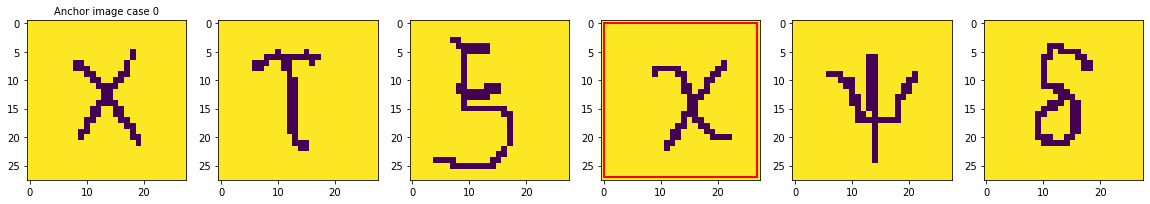

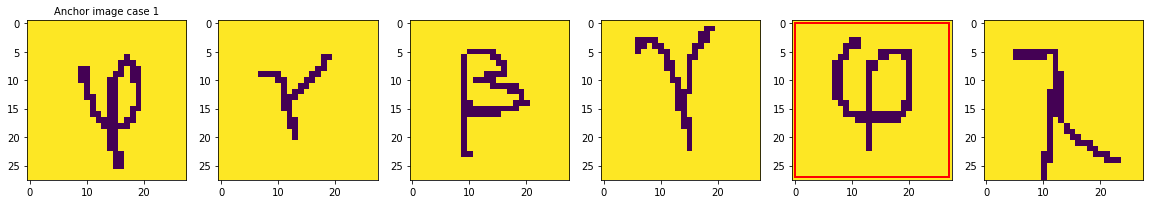

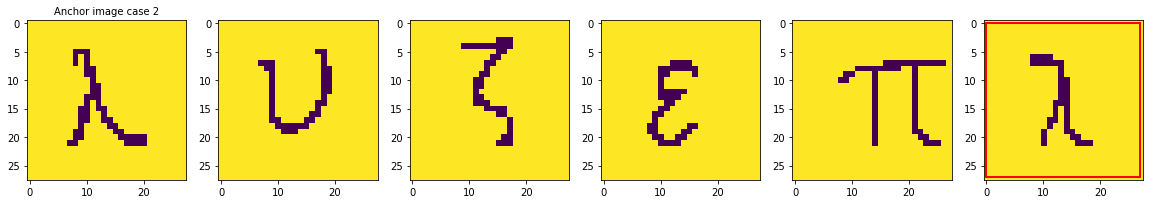

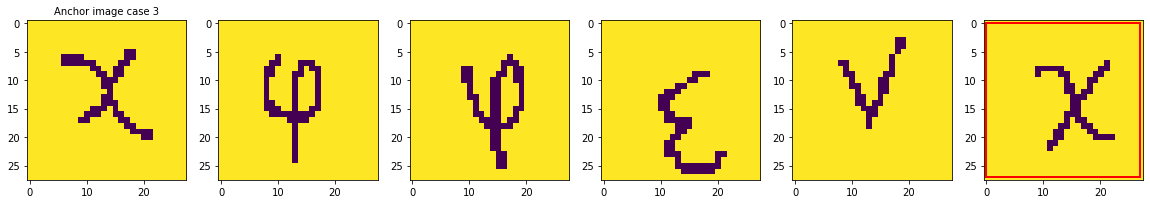

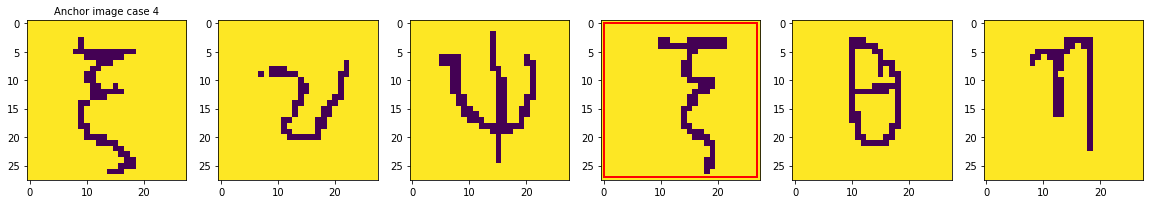

In [4]:
from matplotlib.patches import Rectangle

def plot_case(caseID):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))
    
    # plot anchor image
    axes[0].imshow(queries[caseID, 0])
    axes[0].set_title(f"Anchor image case {caseID}", fontsize=10)
    
    # show all test images images 
    [ax.imshow(candidates_sets[caseID, i]) for i, ax in enumerate(axes[1:])]
    
    
    # Add the patch to the Axes
    axes[queries_true[caseID]].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))
    
    
    
    
# plot the first five samples of the query datset
[plot_case(caseID) for caseID in range(5)] ;

In [5]:
##
# Setting up fit and loss functions as in tutorial 2.1
# 

#Use a train test split on original train set to check model performance
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(train_x_re, train_y_re)

def loss_batch(model, loss_func, xb, yb, opt=None):
    
    output=model(xb)
    loss = loss_func(output, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.data)
    
    return loss.item(), corrects, len(xb)

from tqdm import tqdm
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):

    for epoch in tqdm(range(epochs)):
        
        
        # training process
        model.train()

        running_loss = 0.0
        running_corrects = 0
        sample_num=0
        for xb, yb in train_dl:
            
            # forward
            # backward and optimize only if in training phase
            losses, corrects, nums = loss_batch(model, loss_func, xb, yb,opt)
            
            # statistics
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num+=nums
            
        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num

        
        # validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num=0
            for xb, yb in valid_dl:
                
                # forward
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                
                # statistics
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num+=nums

            val_loss = running_loss / sample_num
            val_acc = running_corrects.double()/ sample_num
            
            
        # print the results
        print(
            f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}',
            end=' '
        )
        print(f'LOSS: {train_loss:.4f}',f'ACC: {train_acc:.4f} ',end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}',f'VAL-ACC: {val_acc:.4f} ',end='\n')

from torch.utils.data import DataLoader
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

from torch.utils.data import TensorDataset
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_test, y_test)

bs=64
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)


In [14]:
from torch import nn
from torch import optim
import torch.nn.functional as F

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

model = nn.Sequential(
    Lambda(preprocess),

    # Conv Layer block 1
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Conv Layer block 2
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Conv Layer block 3
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    Lambda(lambda x: x.view(x.size(0), -1)),

    nn.Linear(2304, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 965),
)

lr = 0.1
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs=40
loss_func = F.cross_entropy

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

  2%|▎         | 1/40 [00:37<24:19, 37.42s/it]

EPOCH: 01/40 LOSS: 6.6552 ACC: 0.0026  VAL-LOSS: 22.0737 VAL-ACC: 0.0009 


  5%|▌         | 2/40 [01:14<23:27, 37.04s/it]

EPOCH: 02/40 LOSS: 5.5091 ACC: 0.0321  VAL-LOSS: 12.8459 VAL-ACC: 0.0011 


  8%|▊         | 3/40 [01:50<22:44, 36.89s/it]

EPOCH: 03/40 LOSS: 4.0927 ACC: 0.1219  VAL-LOSS: 4.4999 VAL-ACC: 0.1019 


 10%|█         | 4/40 [02:29<22:26, 37.42s/it]

EPOCH: 04/40 LOSS: 2.8893 ACC: 0.2876  VAL-LOSS: 27.1255 VAL-ACC: 0.0009 


 12%|█▎        | 5/40 [03:07<21:59, 37.70s/it]

EPOCH: 05/40 LOSS: 2.1186 ACC: 0.4340  VAL-LOSS: 13.6297 VAL-ACC: 0.0040 


 15%|█▌        | 6/40 [03:46<21:43, 38.33s/it]

EPOCH: 06/40 LOSS: 1.6640 ACC: 0.5329  VAL-LOSS: 5.3304 VAL-ACC: 0.1447 


 18%|█▊        | 7/40 [04:24<21:01, 38.21s/it]

EPOCH: 07/40 LOSS: 1.3757 ACC: 0.6015  VAL-LOSS: 26.5416 VAL-ACC: 0.0019 


 20%|██        | 8/40 [05:03<20:28, 38.39s/it]

EPOCH: 08/40 LOSS: 1.1564 ACC: 0.6618  VAL-LOSS: 3.8549 VAL-ACC: 0.2296 


 22%|██▎       | 9/40 [05:41<19:46, 38.28s/it]

EPOCH: 09/40 LOSS: 1.0436 ACC: 0.6897  VAL-LOSS: 24.9718 VAL-ACC: 0.0066 


 25%|██▌       | 10/40 [06:17<18:49, 37.64s/it]

EPOCH: 10/40 LOSS: 0.8972 ACC: 0.7311  VAL-LOSS: 2.1749 VAL-ACC: 0.4998 


 28%|██▊       | 11/40 [06:53<17:54, 37.04s/it]

EPOCH: 11/40 LOSS: 0.8087 ACC: 0.7597  VAL-LOSS: 3.1622 VAL-ACC: 0.4106 


 30%|███       | 12/40 [07:30<17:18, 37.09s/it]

EPOCH: 12/40 LOSS: 0.7478 ACC: 0.7761  VAL-LOSS: 6.4520 VAL-ACC: 0.1560 


 32%|███▎      | 13/40 [08:07<16:38, 36.99s/it]

EPOCH: 13/40 LOSS: 0.7222 ACC: 0.7813  VAL-LOSS: 4.1419 VAL-ACC: 0.2487 


 35%|███▌      | 14/40 [08:43<15:56, 36.79s/it]

EPOCH: 14/40 LOSS: 0.7442 ACC: 0.7744  VAL-LOSS: 1.9502 VAL-ACC: 0.5643 


 38%|███▊      | 15/40 [09:20<15:19, 36.78s/it]

EPOCH: 15/40 LOSS: 0.7518 ACC: 0.7801  VAL-LOSS: 2.5546 VAL-ACC: 0.4081 


 40%|████      | 16/40 [09:57<14:43, 36.83s/it]

EPOCH: 16/40 LOSS: 0.6744 ACC: 0.8011  VAL-LOSS: 1.9389 VAL-ACC: 0.5968 


 42%|████▎     | 17/40 [10:34<14:07, 36.87s/it]

EPOCH: 17/40 LOSS: 0.6642 ACC: 0.8057  VAL-LOSS: 3.0217 VAL-ACC: 0.4091 


 45%|████▌     | 18/40 [11:10<13:22, 36.49s/it]

EPOCH: 18/40 LOSS: 0.6523 ACC: 0.8102  VAL-LOSS: 4.0339 VAL-ACC: 0.3606 


 48%|████▊     | 19/40 [11:54<13:34, 38.77s/it]

EPOCH: 19/40 LOSS: 0.6806 ACC: 0.8051  VAL-LOSS: 2.4196 VAL-ACC: 0.5289 


 50%|█████     | 20/40 [12:41<13:44, 41.22s/it]

EPOCH: 20/40 LOSS: 0.6883 ACC: 0.8060  VAL-LOSS: 2.5222 VAL-ACC: 0.5609 


 52%|█████▎    | 21/40 [13:25<13:22, 42.23s/it]

EPOCH: 21/40 LOSS: 0.6881 ACC: 0.8053  VAL-LOSS: 3.8420 VAL-ACC: 0.4117 


 55%|█████▌    | 22/40 [14:03<12:16, 40.91s/it]

EPOCH: 22/40 LOSS: 0.7179 ACC: 0.8011  VAL-LOSS: 2.3208 VAL-ACC: 0.5760 


 57%|█████▊    | 23/40 [14:39<11:10, 39.45s/it]

EPOCH: 23/40 LOSS: 0.5842 ACC: 0.8327  VAL-LOSS: 2.1245 VAL-ACC: 0.5860 


 60%|██████    | 24/40 [15:17<10:22, 38.93s/it]

EPOCH: 24/40 LOSS: 0.6547 ACC: 0.8216  VAL-LOSS: 3.4242 VAL-ACC: 0.4549 


 62%|██████▎   | 25/40 [15:56<09:45, 39.03s/it]

EPOCH: 25/40 LOSS: 0.6304 ACC: 0.8268  VAL-LOSS: 6.4510 VAL-ACC: 0.2653 


 65%|██████▌   | 26/40 [16:34<09:01, 38.66s/it]

EPOCH: 26/40 LOSS: 0.7155 ACC: 0.8080  VAL-LOSS: 2.4582 VAL-ACC: 0.5591 


 68%|██████▊   | 27/40 [17:11<08:17, 38.30s/it]

EPOCH: 27/40 LOSS: 0.7422 ACC: 0.8050  VAL-LOSS: 3.4984 VAL-ACC: 0.3862 


 70%|███████   | 28/40 [17:50<07:40, 38.36s/it]

EPOCH: 28/40 LOSS: 0.7659 ACC: 0.7979  VAL-LOSS: 2.6473 VAL-ACC: 0.5713 


 72%|███████▎  | 29/40 [18:28<07:02, 38.42s/it]

EPOCH: 29/40 LOSS: 0.7579 ACC: 0.8027  VAL-LOSS: 2.1429 VAL-ACC: 0.5870 


 75%|███████▌  | 30/40 [19:07<06:25, 38.52s/it]

EPOCH: 30/40 LOSS: 0.8143 ACC: 0.7966  VAL-LOSS: 2.3693 VAL-ACC: 0.5670 


 78%|███████▊  | 31/40 [19:46<05:48, 38.70s/it]

EPOCH: 31/40 LOSS: 0.6342 ACC: 0.8308  VAL-LOSS: 2.5329 VAL-ACC: 0.6113 


 80%|████████  | 32/40 [20:24<05:07, 38.43s/it]

EPOCH: 32/40 LOSS: 0.6783 ACC: 0.8301  VAL-LOSS: 2.5711 VAL-ACC: 0.5894 


 82%|████████▎ | 33/40 [21:02<04:28, 38.41s/it]

EPOCH: 33/40 LOSS: 0.6679 ACC: 0.8315  VAL-LOSS: 3.3184 VAL-ACC: 0.5394 


 85%|████████▌ | 34/40 [21:39<03:48, 38.01s/it]

EPOCH: 34/40 LOSS: 0.7564 ACC: 0.8123  VAL-LOSS: 3.2909 VAL-ACC: 0.5038 


 88%|████████▊ | 35/40 [22:17<03:09, 37.94s/it]

EPOCH: 35/40 LOSS: 0.7433 ACC: 0.8135  VAL-LOSS: 4.1951 VAL-ACC: 0.4551 


 90%|█████████ | 36/40 [22:54<02:30, 37.56s/it]

EPOCH: 36/40 LOSS: 0.7422 ACC: 0.8164  VAL-LOSS: 2.7418 VAL-ACC: 0.5383 


 92%|█████████▎| 37/40 [23:31<01:52, 37.38s/it]

EPOCH: 37/40 LOSS: 0.6820 ACC: 0.8309  VAL-LOSS: 4.2539 VAL-ACC: 0.4979 


 95%|█████████▌| 38/40 [24:08<01:14, 37.44s/it]

EPOCH: 38/40 LOSS: 0.7127 ACC: 0.8274  VAL-LOSS: 2.7771 VAL-ACC: 0.5364 


 98%|█████████▊| 39/40 [24:47<00:37, 37.66s/it]

EPOCH: 39/40 LOSS: 0.8435 ACC: 0.8070  VAL-LOSS: 3.3268 VAL-ACC: 0.5004 


100%|██████████| 40/40 [25:24<00:00, 38.11s/it]

EPOCH: 40/40 LOSS: 0.9784 ACC: 0.7791  VAL-LOSS: 4.5570 VAL-ACC: 0.3409 


In [18]:
#other implementation
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(64, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 965),
    
)

lr = 0.1
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs=10
loss_func = F.cross_entropy

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

 10%|█         | 1/10 [00:02<00:25,  2.87s/it]

EPOCH: 01/10 LOSS: 6.8776 ACC: 0.0006  VAL-LOSS: 6.8794 VAL-ACC: 0.0002 


 20%|██        | 2/10 [00:05<00:22,  2.86s/it]

EPOCH: 02/10 LOSS: 6.8693 ACC: 0.0010  VAL-LOSS: 6.8853 VAL-ACC: 0.0004 


 30%|███       | 3/10 [00:08<00:19,  2.85s/it]

EPOCH: 03/10 LOSS: 6.8646 ACC: 0.0009  VAL-LOSS: 6.8910 VAL-ACC: 0.0004 


 40%|████      | 4/10 [00:11<00:17,  2.91s/it]

EPOCH: 04/10 LOSS: 6.8613 ACC: 0.0004  VAL-LOSS: 6.8942 VAL-ACC: 0.0004 


 50%|█████     | 5/10 [00:14<00:15,  3.03s/it]

EPOCH: 05/10 LOSS: 6.8588 ACC: 0.0010  VAL-LOSS: 6.8972 VAL-ACC: 0.0002 


 60%|██████    | 6/10 [00:18<00:12,  3.13s/it]

EPOCH: 06/10 LOSS: 6.8569 ACC: 0.0009  VAL-LOSS: 6.9021 VAL-ACC: 0.0002 


 70%|███████   | 7/10 [00:21<00:09,  3.19s/it]

EPOCH: 07/10 LOSS: 6.8558 ACC: 0.0007  VAL-LOSS: 6.9011 VAL-ACC: 0.0002 


 80%|████████  | 8/10 [00:24<00:06,  3.23s/it]

EPOCH: 08/10 LOSS: 6.8545 ACC: 0.0011  VAL-LOSS: 6.9045 VAL-ACC: 0.0002 


 90%|█████████ | 9/10 [00:28<00:03,  3.26s/it]

EPOCH: 09/10 LOSS: 6.8538 ACC: 0.0007  VAL-LOSS: 6.9051 VAL-ACC: 0.0000 


100%|██████████| 10/10 [00:31<00:00,  3.16s/it]

EPOCH: 10/10 LOSS: 6.8531 ACC: 0.0008  VAL-LOSS: 6.9052 VAL-ACC: 0.0000 


In [ ]:
## #TODO Modify this function such that you implement you character recognition algorithm here
## The test code bellow will call this function with the following parameters 
## query - the query image (28, 28)
## candidates - numpy array of candidate images, shape (5, 28, 28)
## return - sorted array of the indexes of the images based on the similarty to the query image 
def test_model(query, candidates):
  # TODO: dummy output that should be substituted by values produced by your solution
  sorted_indexes = np.array([1, 2, 3, 4, 5]) 

  return sorted_indexes

In [ ]:
## test top-1
def test_top_1(query, candidates, query_true):
  sorted_indexes = test_model(query, candidates)
  return query_true == sorted_indexes[0]

## test top-3
def test_top_3(query, candidates, query_true):
  sorted_indexes = test_model(query, candidates)
  return np.isin(query_true, sorted_indexes[:3])

top_1_res = np.array([test_top_1(a, b, c) for (a, b, c) in zip(queries, candidates_sets, queries_true)])
top_3_res = np.array([test_top_3(a, b, c) for (a, b, c) in zip(queries, candidates_sets, queries_true)])

top_1 = np.count_nonzero(top_1_res) / queries.shape[0]
print(f"top-1 accuracy: {top_1}")

top_3 = np.count_nonzero(top_3_res) / queries.shape[0]
print(f"top-3 accuracy: {top_3}")


top-1 accuracy: 0.25
top-3 accuracy: 0.58
